In [2]:
# Load stored variables
%store -r final_sales_df

## Is there a difference in average order value (AOV) for online vs. In-store sales?

  Online / In-store      AOV
0          In-store  2137.82
1            Online  2043.79



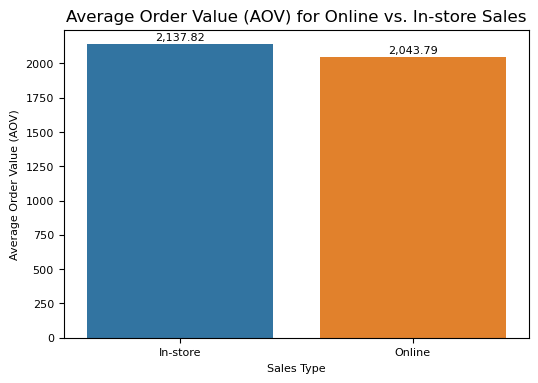

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column 'Online / In-store' based on the 'Store State' column
# Adjust the condition below based on your data (e.g., 'Online' or specific store states)

final_sales_df['Online / In-store'] = final_sales_df['Store State'].apply(lambda x: 'Online' if x == 'Online' else 'In-store')

# Calculate Revenue: Quantity * Unit Price USD
final_sales_df['Revenue'] = final_sales_df['Quantity'] * final_sales_df['Unit Price USD'].astype(float)

# Calculate total revenue and distinct orders per Online/In-store
aov_data = final_sales_df.groupby('Online / In-store').agg(
    Total_Revenue=('Revenue', 'sum'),
    Distinct_Orders=('Order Number', 'nunique')
).reset_index()

# Calculate the Average Order Value (AOV)
aov_data['AOV'] = aov_data['Total_Revenue'] / aov_data['Distinct_Orders']

# Print the AOV for both Online and In-store
print(aov_data[['Online / In-store', 'AOV']].round(2))
print()

# Plot the AOV comparison

plt.figure(figsize=(6, 4))
ax = sns.barplot(data=aov_data, x='Online / In-store', y='AOV', hue='Online / In-store', legend=False)

# Adding values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=8, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.title('Average Order Value (AOV) for Online vs. In-store Sales', fontsize=12)
plt.xlabel('Sales Type', fontsize=8)
plt.ylabel('Average Order Value (AOV)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()


#### The in-store average order value is higher but close to the online amount. We will need to use a statistical test to verify this.

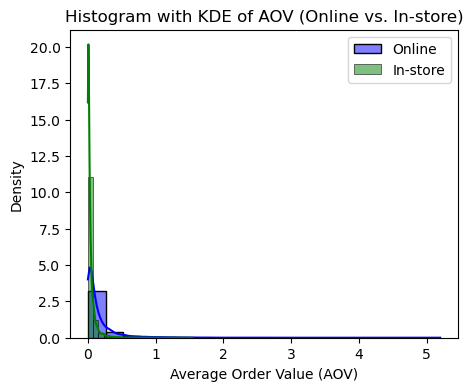

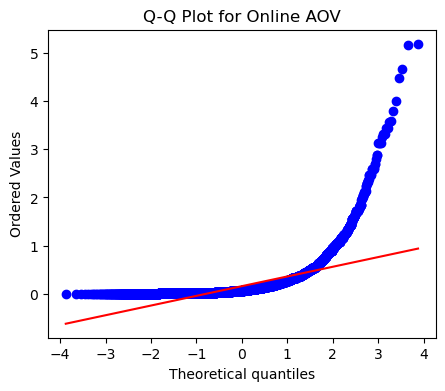

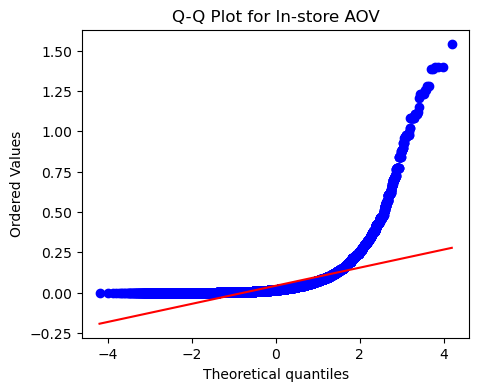

Anderson-Darling Test for Online AOV: 1718.9090
Anderson-Darling Test for In-store AOV: 6647.2943
Online AOV does not follow a normal distribution.
In-store AOV does not follow a normal distribution.


In [24]:
from scipy import stats
from scipy.stats import anderson

# Extract AOV for Online and In-store (AOV is Revenue / Distinct Orders)
online_aov = final_sales_df[final_sales_df['Online / In-store'] == 'Online']['Revenue'] / final_sales_df[final_sales_df['Online / In-store'] == 'Online']['Order Number'].nunique()
in_store_aov = final_sales_df[final_sales_df['Online / In-store'] == 'In-store']['Revenue'] / final_sales_df[final_sales_df['Online / In-store'] == 'In-store']['Order Number'].nunique()

# Plot histogram for both Online and In-store AOV
plt.figure(figsize=(5, 4))
sns.histplot(online_aov, kde=True, color='blue', label='Online', stat='density', bins=20)
sns.histplot(in_store_aov, kde=True, color='green', label='In-store', stat='density', bins=20)
plt.title('Histogram with KDE of AOV (Online vs. In-store)')
plt.xlabel('Average Order Value (AOV)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Q-Q plot for Online AOV
plt.figure(figsize=(5, 4))
stats.probplot(online_aov, dist="norm", plot=plt)
plt.title('Q-Q Plot for Online AOV')
plt.show()

# Q-Q plot for In-store AOV
plt.figure(figsize=(5, 4))
stats.probplot(in_store_aov, dist="norm", plot=plt)
plt.title('Q-Q Plot for In-store AOV')
plt.show()

# Perform Anderson-Darling test for Online AOV
online_anderson_result = anderson(online_aov)
print(f'Anderson-Darling Test for Online AOV: {online_anderson_result.statistic:.4f}')

# Perform Anderson-Darling test for In-store AOV
in_store_anderson_result = anderson(in_store_aov)
print(f'Anderson-Darling Test for In-store AOV: {in_store_anderson_result.statistic:.4f}')

# Interpret the result
alpha = 0.05  # Significance level (5%)
if online_anderson_result.statistic > online_anderson_result.critical_values[2]:
    print("Online AOV does not follow a normal distribution.")
else:
    print("Online AOV follows a normal distribution.")

if in_store_anderson_result.statistic > in_store_anderson_result.critical_values[2]:
    print("In-store AOV does not follow a normal distribution.")
else:
    print("In-store AOV follows a normal distribution.")

#### The distributions of online and in-store order averages are not normal. The Mann-Whitney U Test is used to check the difference in AOV.

In [26]:
# Separate the data into Online and In-store groups
online_aov = final_sales_df[final_sales_df['Online / In-store'] == 'Online']['Revenue'] / final_sales_df[final_sales_df['Online / In-store'] == 'Online']['Order Number'].nunique()
in_store_aov = final_sales_df[final_sales_df['Online / In-store'] == 'In-store']['Revenue'] / final_sales_df[final_sales_df['Online / In-store'] == 'In-store']['Order Number'].nunique()

# Perform the Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(online_aov, in_store_aov, alternative='two-sided')

# Display the results
print(f'U-statistic: {u_stat:.2f}')
print(f'P-value: {p_value:.4f}')

# Interpret the result
alpha = 0.05  # Significance level (5%)

if p_value < alpha:
    print("The difference in AOV between Online and In-store sales is statistically significant.")
else:
    print("The difference in AOV between Online and In-store sales is not statistically significant.")

U-statistic: 468517349.00
P-value: 0.0000
The difference in AOV between Online and In-store sales is statistically significant.


#### The difference is statistically significant, which could be due to the different number of orders in each group.